# Assignment 2 (100 points)

You are expected to complete this notebook with lines of code, plots and texts. You might need to create new cells with original code or text for your analyses. This assignment has a total of 100 points.

For assignment submission, you will submit this notebook file (.ipynb) on Canvas with cells executed and outputs visible. Your submitted notebook **must** follow these guidelines:
- No other dataset than the provided datasets should be used.
- Training, validation and testing splits should be the same as the ones provided.
- The cell outputs in your delivered notebook should be reproducible.
- Printing out the evaluation metric evidence that your model achieves the evaluation requirement. Optionally, you can also add plot of the evaluation metric changing over the course of training process.
- Providing code associated with the conclusions you make in your analysis as well as code that is used to generated plot, images, etc. for your analysis.
- All code must be your own work. Code cannot be copied from external sources or another students. You may copy code from cells that are pre-defined in this notebook if you think it is useful to reuse in another question.
- All images must be generated from data generated in your code. Do **NOT** import/display images that are generated outside your code.
- Your analysis must be your own, but if you quote text or equations from another source please make sure to cite the appropriate references.
- Your input with code will be marked with comments ``###your code starts here###`` and ``###your code ends here###`` to specify where you need to write your code. You can also create a new code cell in between those marked comments.


**NOTES:**
- PyTorch needs to be downloaded and installed properly.
- You should use PyTorch 1.7 or later.
- If you need to import a different package than the ones already imported, please check with the TA if you can do so.
- Cells should be run in order, using Shift+Enter.
- Read all the provided code cells and comments as they contain variables and information that you may need to use to complete the notebook.
- To create a new text cell, select "+" button on the menu bar and change its type from "Code" to "Markdown".
- To modify a text cell, double click on it.
- More details on how to format markdown text can be found here: https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed
- Your home directory on CADE machines has a small disk quota. It might be necessary, depending on how much your home directory is already occupied, to store the virtual environment inside a folder in ```/scratch/tmp/```. 
- **The accuracy requirement for each question is there to make sure you have performed sufficient amount of experiments to achieve a good result. Part of the grade is based on this.**

**Tips for training deep learning models:**
- Since the datasets being used here are small, you are probably going to have to use early stopping to prevent overfitting. This means that you will have to save your models in the middle of training. One of the ways to do so is to make a deep copy of it using ```copy.deepcopy``` function. 
- It is recommended to frequently monitor the behavior of the model at least once every epoch. You can either print out the training loss or evaluation metric of the training set to verify that the model is being optimized correctly. In this assignment, it should take somewhere between 1 and 20 epochs for a desired model to achieve the required accuracy.
- To search for the best hyperparameters for your model, it is usually better to start searching in a logarithmic scale. Usually power of 2 or 10 is used. 
- In https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2, an ablation study in finding optimal learning rates for different optimizers are listed. This could help in your search of optimal learning rate. For this assignment, you will probably get the best results with Adam optimizer and searching for the best learning rate in the range of learning rates provided in that article, which is from 0.00005 to 0.01 unless a question is asked to use a specific optimizer.
- Batch size seems to have a smaller impact than learning rate in the results. It should be enough if you test batch sizes between 8 and 32.
- We assume a GPU of at least 4GB of memory is available. If you want to try running the assignment with a GPU that has less than that, you can try changing the argument passed when calling the ```define_gpu_to_use``` function.  If you are getting out-of-memory errors for the GPU, you may want to check what is occupying the GPU memory by using the command ```!nvidia-smi```, which gives a usage report of the GPU. However, if you are using your own Windows machine, the nvidia-smi command used in the define_gpu_to_use function will not work. You can skip running this function but please check to make sure your GPU has a sufficient amount of free memory.
- For some of the questions, it might be useful for you to understand what the ResNet-18 PyTorch model is doing. You can have access to its source code here (https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py). The most important part you should know is the ```forward``` function from the ```ResNet``` class. 
- It might also be useful to print PyTorch models using ```print("model_name")```. This should give you a list of all the layers in the model.
- Here are a few PyTorch details not to forget:
    - Toggle train/eval mode for your model
    - Reset the gradients with ```zero_grad()``` before each call to ```backward()```
    - Check if the loss you are using receives logits or probabilities, and adapt your model output accordingly.
    - Reinstantiate your model every time you are starting a new training so that the weights are reset, if you plan to reuse the variable name.
    - Pass the model's parameters to the optimizer.

# Exercise 0 - Set-up Infrastructure (Total of 0 points)
## + Install Libraries:

In [1]:
!pip3 install -q kaggle
!pip3 install pydicom
!pip3 install scikit-learn

## + Import Libraries:

In [2]:
import getpass
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sys
from sklearn.metrics import roc_curve, auc
import copy
import torchvision.models as models
import tarfile
import time
from packaging import version
%matplotlib inline

##### Check Torch library requirement #####
my_torch_version = torch.__version__
minimum_torch_version = '1.7'
if version.parse(my_torch_version) < version.parse(minimum_torch_version):
    print('Warning!!! Your Torch version %s does NOT meet the minimum requirement!\
            Please update your Torch library\n' %my_torch_version)

## + Create Data Folder:

In [3]:
##### Check what kind of system you are using #####
try:
    hostname = !hostname
    if 'lab' in hostname[0] and '.eng.utah.edu' in hostname[0]:
        IN_CADE = True
        print("Cade running successfully")
    else:
        IN_CADE = False
except:
    IN_CADE = False

## Define the folders where datasets will be
machine_being_used = 'cade' if IN_CADE else ('other')
pre_folder = '/scratch/tmp/' if machine_being_used == 'cade' else './'
mnist_dataset_folder = pre_folder + 'deep_learning_datasets_ECE_6960_013/mnist'
xray14_dataset_folder = pre_folder + 'deep_learning_datasets_ECE_6960_013/chestxray14'

## Create directory if they haven't existed yet 
if not os.path.exists(mnist_dataset_folder):
    os.makedirs(mnist_dataset_folder)    
if machine_being_used != 'cade' and not os.path.exists(mnist_dataset_folder+'/MNIST'):        
    os.makedirs(mnist_dataset_folder+'/MNIST')
if machine_being_used != 'cade' and not os.path.exists(mnist_dataset_folder+'/MNIST/raw'):
    os.makedirs(mnist_dataset_folder+'/MNIST/raw')
if not os.path.exists(xray14_dataset_folder):
    os.makedirs(xray14_dataset_folder)

## + Request GPU Usage:

In [4]:
##### Request a GPU #####
## This function locates an available gpu for usage. In addition, this function reserves a specificed
## memory space exclusively for your account. The memory reservation prevents the decrement in computational
## speed when other users try to allocate memory on the same gpu in the shared systems, i.e., CADE machines. 
## Note: If you use your own system which has a GPU with less than 4GB of memory, remember to change the 
## specified mimimum memory.
def define_gpu_to_use(minimum_memory_mb = 3500):    
    thres_memory = 600 #
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    
    torch.cuda.empty_cache()
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader        
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        
        if free_memory>minimum_memory_mb-thres_memory:
            gpu_to_use = i
            break
            
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' + str(minimum_memory_mb) \
              + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use))
        x = torch.rand((256,1024,minimum_memory_mb-thres_memory)).cuda()
        x = torch.rand((1,1)).cuda()        
        del x
        
## Request a gpu and reserve the memory space
define_gpu_to_use()

Chosen GPU: 0


## + Define Utility Functions:

In [5]:
##### Preprocess Image #####
## This function is used to crop the largest 1:1 aspect ratio region of a given image.
## This is useful, especially for medical datasets, since many datasets have images
## with different aspect ratios and this is one way to standardize inputs' size.
class CropBiggestCenteredInscribedSquare(object):
    def __init__(self):
        pass

    def __call__(self, tensor):
        longer_side = min(tensor.size)
        horizontal_padding = (longer_side - tensor.size[0]) / 2
        vertical_padding = (longer_side - tensor.size[1]) / 2
        return tensor.crop(
            (
                -horizontal_padding,
                -vertical_padding,
                tensor.size[0] + horizontal_padding,
                tensor.size[1] + vertical_padding
            )
        )

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [6]:
##### Split a dataset for training, validatation, and testing #####
## This function splits a given dataset into 3 subsets of 60%-20%-20% for train-val-test, respectively.
## This function is used internally in the dataset classes below.
def get_split(array_to_split, split):
    np.random.seed(0)
    np.random.shuffle(array_to_split)
    np.random.seed()
    if split == 'train':
        array_to_split = array_to_split[:int(len(array_to_split)*0.6)]
    elif split == 'val':
        array_to_split = array_to_split[int(len(array_to_split)*0.6):int(len(array_to_split)*0.8)]
    elif split == 'test':
        array_to_split = array_to_split[int(len(array_to_split)*0.8):]
    return array_to_split


In [7]:
##### Compute the number parameters (weights) #####
## This function computes the number of learnable parameters in a Pytorch model
def count_number_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Exercise 1 - MNIST Dataset and CNNs (Total of 32 points)
We begin this assignment by revisiting one of the problems from the previous assignment. Previously, we built a simple two-layer neural network to classify images containing hand-written digits. In this exercise, we are going to replace that two-layer neural network with a convolutional neural network. First, we load the images that we are going to work with into Pytorch Dataloader, and then define an evaluation metric for it.

In [8]:
##### Load MNIST dataset to Pytorch Dataloader #####
## Dowloand MNIST dataset train set from Pytorch (60,000 images total)
mnist_training_data = torchvision.datasets.MNIST(mnist_dataset_folder, train = True, \
                                        transform=transforms.ToTensor(), \
                                        target_transform=None, \
                                        download= True)
print('A summary of MNIST dataset:\n')
print(mnist_training_data,'\n')
## Dowloand MNIST dataset test set from Pytorch (10,000 images total)
mnist_test_data = torchvision.datasets.MNIST(mnist_dataset_folder, train = False, \
                                        transform=transforms.ToTensor(), \
                                        target_transform=None, \
                                        download= True)
print(mnist_test_data)
## Randomly split training images into 80%/20% for training/validation process
train_data_ex1, val_data_ex1 = torch.utils.data.random_split(mnist_training_data, \
                                    [int(0.8*len(mnist_training_data)),\
                                     len(mnist_training_data)-int(0.8*len(mnist_training_data))], \
                                     generator=torch.Generator().manual_seed(1))

assert(len(mnist_test_data) == 10000)
assert(len(train_data_ex1)+len(val_data_ex1) == 60000)

## Load files to Pytorch dataloader for training, validation, and testing
train_loader_ex1 = torch.utils.data.DataLoader(train_data_ex1, batch_size=16, shuffle=True, num_workers=8)
val_loader_ex1 = torch.utils.data.DataLoader(val_data_ex1, batch_size=128, shuffle=True, num_workers=8)
test_loader_ex1 = torch.utils.data.DataLoader(mnist_test_data, batch_size=128, shuffle=False, num_workers=8)

A summary of MNIST dataset:

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./deep_learning_datasets_ECE_6960_013/mnist
    Split: Train
    StandardTransform
Transform: ToTensor() 

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./deep_learning_datasets_ECE_6960_013/mnist
    Split: Test
    StandardTransform
Transform: ToTensor()


In [9]:
##### Compute accuracy for MNIST dataset #####
def get_accuracy_mnist(model, data_loader):
    ## Toggle model to eval mode
    model.eval()
    
    ## Iterate through the dataset and perform inference for each sample.
    ## Store inference results and target labels for AUC computation 
    with torch.no_grad():
        #run through several batches, does inference for each and store inference results
        # and store both target labels and inferenced scores
        acc = 0.0
        for image, target in data_loader:
            image = image.cuda(); target = target.cuda()
            probs = model(image)
            preds = torch.argmax(probs, 1)
            acc += torch.count_nonzero(preds == target)
                
        return acc/len(data_loader.dataset)
        

Now, your task is to implement a convolutional neural network, named ``model_ex1``, with the following order and set-up:
- Zero padding the image boundaries with 2 additional pixels
- Convolution Layer 1 - kernel size = 5; output features = 6; padding = 0; stride = 1; containing bias
- Relu Activation Function
- Max Pooling Layer 1 - kernel size = 2; stride = 2
- Convolution Layer 2 - kernel size = 5; output features = 16; padding = 0; stride = 1; containing bias
- Relu Activation Function
- Max Pooling Layer 2 - kernel size = 2; stride = 2
- Convolution Layer 3 - kernel size = 5; output features = 120; padding = 0; stride = 1; containing bias
- Relu Activation Function
- Fully-connected Layer 1 - input features = 120; output features = 84; containing bias
- Drop-out Layer - with dropout probability of 0.5
- Relu Activation Function
- Fully-connected Layer 2 - input features = 84; output features = 10; containing bias

In [10]:
##### Implement a CNN, named model_ex1, with the architecture specified above #####
### Your code starts here ###
import torch.nn as nn

class Flatten(nn.Module):
	def forward(self, x):
		return x.view(x.size(0), -1)

class model_ex1(nn.Module):
	def __init__(self):
		super(model_ex1, self).__init__()
  
		self.layers = nn.Sequential(
            nn.ZeroPad2d(2),
            
			nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=0, stride=1, bias=True),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2, stride=2),
   
			nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0, stride=1, bias=True),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2, stride=2),
   
			nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, padding=0, stride=1, bias=True),
			nn.ReLU(),
   
			Flatten(),
   
			nn.Linear(120, 84),
			nn.Dropout(0.5),
			nn.ReLU(),
   
			nn.Linear(84, 10)
			
		)
		
	def forward(self, x):
		return self.layers(x)

## Some Test Code
# m = model_ex1()
# input_ = torch.zeros(1,1,28,28)
# output_ = m(input_)

### Your code ends here ###

Next, you will implement the training process for ``model_ex1`` using stochastic gradient descent algorithm to optimize the softmax cross-entropy loss function. Your best trained model must meet the following requirements:
- Your best model should be named ``best_model_ex1``.
- Obtaining at least 98.5\% accuracy on the validation set.

In [11]:
def weight_init(module, initf):
	def foo(m):
		classname = m.__class__.__name__.lower()
		if isinstance(m, module):
			initf(m.weight)
	return foo

In [12]:
##### Training Process #####
### Your code starts here ###
from collections import defaultdict

DEVICE = "cuda:0"
model_ex1_1 = model_ex1()
model_ex1_1.to(DEVICE)
model_ex1_1.apply(weight_init(module=nn.Conv2d, initf=nn.init.kaiming_uniform_))
model_ex1_1.apply(weight_init(module=nn.Linear, initf=nn.init.kaiming_uniform_))
num_epochs = 100

optimizer = torch.optim.SGD(model_ex1_1.parameters(), lr=1e-2)
optimizer.zero_grad()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)
criterion_ce = nn.CrossEntropyLoss()
prev_acc = 0

save_dir = os.path.join(pre_folder, "save_model_ex1_1")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    model_ex1_1.train()
    loss_dict = defaultdict(list)
    for image, labels in train_loader_ex1:
        optimizer.zero_grad()
        image = image.to(DEVICE)
        labels = labels.to(DEVICE)
        output = torch.softmax(model_ex1_1(image), dim=1)
        final_loss = criterion_ce(output, labels)
        final_loss.backward()
        optimizer.step()
        loss_dict["ce"].append(final_loss.detach().cpu())
    
    print(f'Train Loss after {epoch} epochs = {np.mean(np.array(loss_dict["ce"]))}')
    train_acc = get_accuracy_mnist(model_ex1_1, train_loader_ex1)
    val_acc = get_accuracy_mnist(model_ex1_1, val_loader_ex1)
    print(f'Train accuracy={train_acc}, Val accuracy={val_acc}')
    
    if val_acc > prev_acc:
        torch.save(model_ex1_1.state_dict(), os.path.join(save_dir, "model_best.torch"))
        prev_acc = val_acc
    
    if val_acc > 0.985:
        print("Accuracy of 98.5% reached - stopping model")
        best_model_ex1 = copy.deepcopy(model_ex1_1)
        break
    
    if epoch != 0 and epoch % 10 == 0:
        scheduler.step()
### Your code ends here ###

Train Loss after 0 epochs = 1.7977044582366943
Train accuracy=0.9214583039283752, Val accuracy=0.9213333129882812
Train Loss after 1 epochs = 1.570986032485962
Train accuracy=0.9457499980926514, Val accuracy=0.9466666579246521
Train Loss after 2 epochs = 1.5392122268676758
Train accuracy=0.9598749876022339, Val accuracy=0.9592499732971191
Train Loss after 3 epochs = 1.5245282649993896
Train accuracy=0.9661041498184204, Val accuracy=0.9634166359901428
Train Loss after 4 epochs = 1.5149410963058472
Train accuracy=0.968874990940094, Val accuracy=0.9683333039283752
Train Loss after 5 epochs = 1.5090411901474
Train accuracy=0.9722291827201843, Val accuracy=0.9711666703224182
Train Loss after 6 epochs = 1.5046164989471436
Train accuracy=0.973229169845581, Val accuracy=0.9721666574478149
Train Loss after 7 epochs = 1.5008835792541504
Train accuracy=0.9748749732971191, Val accuracy=0.9745833277702332
Train Loss after 8 epochs = 1.499266266822815
Train accuracy=0.9744791388511658, Val accuracy=

Lastly, we are going to evaluate your best trained model on the test set.

In [13]:
##### Inference stage for MNIST dataset #####
test_acc = get_accuracy_mnist(best_model_ex1, test_loader_ex1)
print('MNIST Test Accuracy: %.3f%%' %(test_acc*100))

MNIST Test Accuracy: 98.820%


# Exercise 2 - ChestXray14 Dataset (Total of 68 points)
>### Brief explanation of the dataset
> The ChestXray14 dataset contains more than 100,000 frontal chest x-rays and labels for 14 different conditions. These labels were extracted from radiologists' reports associated with each image using natural language processing techniques. It was released at the end of 2017 and was the largest publicly available x-rays dataset for developing deep learning models at the time. More information about the ChestXray14 dataset can be found here: https://stanfordmlgroup.github.io/projects/chexnet/. 

In this exercise, we will be using only a subset of this dataset, 14,999 images in total. The labels of this dataset follow a multi-label structure, which means that each image can have more than one label. First, we need to obtain the dataset. Please download the file **Data_Entry_2017_v2020.csv** from https://nihcc.app.box.com/v/ChestXray-NIHCC and **image_names_chestxray14.csv** from Canvas, and put them in the same directory as this notebook.

In [14]:
## Download part of the dataset if it was not downloaded yet and 
## put it to the xray14_dataset_folder folder

##### Report download status #####
def report_hook(count_so_far, block_size, total_size):
    current_percentage = (count_so_far * block_size * 100 // total_size)
    previous_percentage = ((count_so_far - 1) * block_size * 100 // total_size)
    if current_percentage != previous_percentage:
        sys.stdout.write('\r' + str((count_so_far * block_size * 100 // total_size)) \
                         + '% of download completed')
        sys.stdout.flush()

##### Download a subset of ChestXray14 dataset #####        
if xray14_dataset_folder != '/scratch/tmp/deep_learning_datasets_ECE_6960_013/chestxray14':
    os.makedirs(xray14_dataset_folder, exist_ok=True)
    from urllib.request import urlretrieve
    destination_file = xray14_dataset_folder + '/images_4.tar.gz'
    link = 'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz'
    if not os.path.isfile(destination_file):
        urlretrieve(link, destination_file, reporthook = report_hook)

    destination_file = xray14_dataset_folder + '/images_1.tar.gz'
    link = 'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz'
    if not os.path.isfile(destination_file):
        urlretrieve(link, destination_file, reporthook = report_hook)        
    
##### Extract the downloaded file #####
if xray14_dataset_folder != '/scratch/tmp/deep_learning_datasets_ECE_6960_013/chestxray14':
    destination_file = xray14_dataset_folder + '/images_4.tar.gz'
    tar = tarfile.open(destination_file, "r:gz")
    tar.extractall(path = xray14_dataset_folder)
    tar.close()
    destination_file = xray14_dataset_folder + '/images_1.tar.gz'
    tar = tarfile.open(destination_file, "r:gz")
    tar.extractall(path = xray14_dataset_folder)
    tar.close()

Next, we create a Pytorch class structure for this dataset. The dataset class is used to load, index, and preprocess samples for training, validation, and testing process.

In [15]:
class Chestxray14Dataset(Dataset):
    ##### Initialize the class #####
    def __init__(self, path_dataset_folder, split = 'train'):
        ## Split parameter is used to specify which process the data is used for,
        ## and it can be 'train', 'val', and 'test'
        
        self.path_image_folder = path_dataset_folder + '/images'
        
        ## Get the filenames of all images in the dataset
        all_images_list = pd.read_csv('image_names_chestxray14.csv')

        ## Read the labels file which needs to be placed in the same folder as this notebook
        label_file = pd.read_csv('./Data_Entry_2017_v2020.csv')
        
        ## Merge labels and images information
        examples_to_use = pd.merge(all_images_list, label_file)
        
        ## This is the name of all possible labels in this dataset.
        ## The corresponding label of each sample is an array of 14 elements in which the elements are ordered
        ## in the same way as "self.set_of_finding_labels" and the value of each element represents the 
        ## presence of that condition in the sample. For example, if "cardiomegaly" and "pneumonia" are the two 
        ## conditions presence a given sample, then the corresponding label of that sample is represented 
        ## by an array  - [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
        self.set_of_finding_labels = ['Atelectasis', 'Cardiomegaly','Effusion',  'Infiltration', 'Mass',\
                                      'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', \
                                      'Emphysema', 'Fibrosis','Pleural_Thickening', 'Hernia' ]
        
        ## Read labels from the label file
        examples_to_use['Finding Labels'] = examples_to_use['Finding Labels'].str.split(pat = '|')
        examples_to_use['Finding Labels'] = examples_to_use['Finding Labels'].apply(list).\
                                            to_frame(name='Finding Labels')
        for finding_label in self.set_of_finding_labels:
            examples_to_use[finding_label] = examples_to_use.apply(\
                                            lambda x: int(finding_label in x['Finding Labels']), axis=1)
        
        ## Get the list of all patient ids present in the dataset and split into
        ## training, validation and testing by patient id, but not by list of examples
        patient_ids = pd.unique(examples_to_use['Patient ID'])
        patient_ids = pd.DataFrame(get_split(patient_ids, split), columns = ['Patient ID'])
        
        ## Filter the examples to only use the ones that have the chosen patient ids
        examples_to_use = pd.merge(patient_ids,examples_to_use)        
        
        examples_to_use = examples_to_use[['Image Index'] + self.set_of_finding_labels]
        self.image_list = examples_to_use['Image Index'].values
        self.targets = examples_to_use[self.set_of_finding_labels].values
        
        ## Define data augmentation transformations for the input images. In this exercise, we use the following
        ## transformations: square center cropping, resizing to 224x224 (to be similar as ImageNet dataset), 
        ## converting to tensor, normalizing per channel (i.e., R, G, and B) 
        ## with the average and standard deviation of images in the ImageNet dataset        
        self.set_of_transforms = transforms.Compose(
        [CropBiggestCenteredInscribedSquare(),
         transforms.Resize(224),
         transforms.ToTensor(), 
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
        
    ##### Retrieve a sample with the corresponding index #####
    ## This function retrieve a sample from the dataset at the specified index 
    ## and returns an image and the corresponding label stored in Pytorch tensors     
    def __getitem__(self, index):
        curr_pil_image = Image.open(self.path_image_folder + '/' + self.image_list[index]).convert('RGB')
        image_to_return = self.set_of_transforms(curr_pil_image)
                
        return image_to_return, torch.FloatTensor(self.targets[index])
    
    ##### Get the length of the dataset #####
    def __len__(self):
        return len(self.image_list)
    
    ##### Access the name of conditions in the labels #####
    def get_labels_name(self):
        return self.set_of_finding_labels

We will then use the class function above to create structures for each training, validation, and test set.

In [16]:
## Create datasets for this exercise
train_dataset_ex2 = Chestxray14Dataset(xray14_dataset_folder)
val_dataset_ex2 = Chestxray14Dataset(xray14_dataset_folder, split = 'val')
test_dataset_ex2 = Chestxray14Dataset(xray14_dataset_folder, split = 'test')


## Please contact the TA if any of the assertions fails
assert(len(train_dataset_ex2) == 8837)
assert(len(val_dataset_ex2) == 2924)
assert(len(test_dataset_ex2) == 3238)
assert(np.sum(train_dataset_ex2.targets)==5893)
assert(np.sum(train_dataset_ex2.targets[:,7])==404)
assert(np.sum(val_dataset_ex2.targets)==1810)

Now, we report a statistical summary of the training set to get an idea of what this dataset looks like. We also show a sample of this dataset to get ourselves familiar with the type of images we are working with in this exercise. 

Percentage of positive examples in each class in the training set: 

Atelectasis: 9.99%,
Cardiomegaly: 2.59%,
Effusion: 10.97%,
Infiltration: 14.20%,
Mass: 4.35%,
Nodule: 5.77%,
Pneumonia: 1.01%,
Pneumothorax: 4.57%,
Consolidation: 3.45%,
Edema: 1.56%,
Emphysema: 2.43%,
Fibrosis: 2.41%,
Pleural_Thickening: 3.02%,
Hernia: 0.36%


Showing one example from the dataset:

Atelectasis: 1.0,
Cardiomegaly: 0.0,
Effusion: 0.0,
Infiltration: 0.0,
Mass: 0.0,
Nodule: 0.0,
Pneumonia: 0.0,
Pneumothorax: 0.0,
Consolidation: 1.0,
Edema: 0.0,
Emphysema: 0.0,
Fibrosis: 0.0,
Pleural_Thickening: 0.0,
Hernia: 0.0


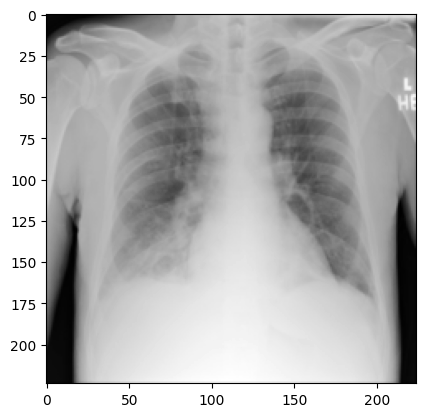

In [17]:
##### Helper function for display text below #####
def join_str_array_to_labels(str_array,labels):
    return ','.join(['\n{}: {}'.format(labels[index_element], str_array_element) 
                for index_element, str_array_element in enumerate(str_array)])

## Show the statistics of training set
frequencies = np.sum(train_dataset_ex2.targets, axis = 0)/len(train_dataset_ex2)
text_frequencies = ['{:.2f}%'.format(frequency*100) for frequency in frequencies]                    
print('Percentage of positive examples in each class in the training set: ')
print(join_str_array_to_labels(text_frequencies, train_dataset_ex2.get_labels_name()))

## Plot a sample from the training set
print('\n\nShowing one example from the dataset:')
plt.imshow(train_dataset_ex2[1][0].cpu().numpy()[0,:,:], cmap = 'gray')
print(join_str_array_to_labels(train_dataset_ex2[1][1],train_dataset_ex2.get_labels_name()))


For this exercise, we will use AUC (also called AUROC) metric to evaluate the performance of a model. The AUC metric is defined as the area under the Receiver Operating Characteristic (ROC) curve, and has a value between 0 and 1. An AUC of 0.5 is what a model producing random outputs can maximally achieve. The higher the AUC is the better the model. In medical related applications, we want to avoid false negatives or false positives outcomes. Thus, the ROC curve is frequently used because it measures the trade-off between false positives and false negatives (sensitivity and specificity to be precise) of a model. Besides, ROC is insensitive to imbalanced datasets. We will define this metric in the cell below.

In [18]:
##### Calculate AUC metric #####
## This function compute AUC from the given input arrays i.e., predicted value and ground truth arrays
def auroc(logits_predicted, target):
    fpr, tpr, _ = roc_curve(target, logits_predicted)
    return auc(fpr, tpr)

##### Compute AUC of a given dataset #####
## This function takes a model and Pytorch data loader as input. 
## The given model is used to predict the expected label for each sample in the Pytorch data loader. The 
## model output for each sample is an array with 14 elements corresponding with 14 conditions in the 
## ChestXray14 dataset. Then, the AUC is computed for each condition.
def get_score_model_chestxray_binary_model(model, data_loader):
    ## Toggle model to eval mode
    model.eval()
    
    ## Iterate through the dataset and perform inference for each sample.
    ## Store inference results and target labels for AUC computation 
    with torch.no_grad():
        
        logits_predicted = np.zeros([0, 14])
        targets = np.zeros([0, 14])
        ## Iterate through the dataset and perform inference for each sample.
        ## Store inference results and target labels for AUC computation  
        for image, target in data_loader:
            image = image.cuda()
            logit_predicted = model(image)
            logits_predicted = np.concatenate((logits_predicted, logit_predicted.cpu().detach().numpy())\
                                              , axis = 0)
            targets = np.concatenate((targets, target.cpu().detach().numpy()), axis = 0)
            
    ## Return a list of auc values in which each value corresponds to one of the 14 labels
    return [auroc(logits_predicted[:,i], targets[:,i]) for i in range(14)]

## Exercise 2.1 - Adopt an ImageNet Pretrained Model (34 points)
In this section, you will adopt ResNet-18 pretrained on Imagenet dataset provided in the torchvision package from Pytorch library (https://pytorch.org/docs/stable/torchvision/models.html#id3) for ChestXray14 dataset. To obtain that goal, our tasks are as follows:
- Setting up Pytorch dataloader for training, validation, and test sets
- Modifying the ResNet-18 model to have 14 neurons, which corresponds to 14 labels, in the output layer
- Selecting a loss function and justify your choice

In [19]:
##### Set-up Pytorch dataloader #####
### Your code starts here ###
train_loader_ex2 = torch.utils.data.DataLoader(train_dataset_ex2, batch_size=8, shuffle=True, num_workers=8)
val_loader_ex2 = torch.utils.data.DataLoader(val_dataset_ex2, batch_size=64, shuffle=True, num_workers=8)
test_loader_ex2 = torch.utils.data.DataLoader(test_dataset_ex2, batch_size=64, shuffle=False, num_workers=8)
### Your code ends here ###

In [20]:
##### Modify ResNet-18 #####
### Your code starts here ###

import torch.nn as nn

class Flatten(nn.Module):
	def forward(self, x):
		return x.view(x.size(0), -1)

class model_ex2_resnet(nn.Module):
	def __init__(self):
		super(model_ex2_resnet, self).__init__()
        
		#self.model = torchvision.models.resnet18(weights='DEFAULT')
		self.model = torchvision.models.resnet18(pretrained=True)
		num_ftrs = self.model.fc.in_features
		# for param in self.model.parameters():
		# 	param.requires_grad = False

		self.model.fc = nn.Sequential(
			nn.Dropout(0.2),
      		nn.Linear(num_ftrs, 14),
			nn.Sigmoid(),
		)

		
	def forward(self, x):
		x = self.model(x)
		return x

# ### Test code
# m = model_ex2_resnet()
# print(m)
### Your code ends here ###

**Write a short reasoning for your loss function selection:**

### Loss Function -
Given in ChestXRay dataset are images and their corresponding 14 labels, and each image can belong to multiple classes, so we can treat it as simple binary classification for each individual 14 classes, hence Binary Cross Entropy Loss makes sense. But as can be seen from the examples that the percentage of positive examples for each class is very less compared to negative examples, we have an unproportaional data in this case and this might lead to bad performance when using just BCE, so we will use a modified version of BCE called weighted binary cross entropy where the weights for negative are the frequencies of postive example and weights for positive examples are frequencies of negative (1 - postive_freq) examples.

$L(x) = -\cfrac{1}{N}(\sum_{postive}w_py\log(f(x)) + \sum_{negative}w_n(1-y)\log(1-f(x)))$

I have implmented a custom function to calculate this loss.

In [21]:
##### Define loss function #####
### Your code starts here ###

def weighted_bce(predicted, target, pw, nw):
    epsilon = 1e-7
    result = - ((pw * target * torch.log(predicted+epsilon)) + (nw * (1-target) * torch.log(1-predicted+epsilon)))
    result = torch.mean(result, dim=1)
    return torch.sum(result) / predicted.shape[0]

### Your code ends here ###

Now, you will implement the training process for the modified ResNet-18 model. Your best trained model must achieve the mean AUC of 14 classes of at least 0.725 on the validation set.

In [22]:
def weight_init(module, initf):
	def foo(m):
		classname = m.__class__.__name__.lower()
		if isinstance(m, module):
			initf(m.weight)
	return foo

In [28]:
##### Training Process #####
### Your code starts here ###

DEVICE = "cuda:0"
model_ex2_1 = model_ex2_resnet()
model_ex2_1.to(DEVICE)
num_epochs = 100

optimizer = torch.optim.Adam(model_ex2_1.model.parameters(), 1e-4, betas=(0.9, 0.999), weight_decay=1e-4)
optimizer.zero_grad()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

neg_weights = torch.tensor(frequencies).cuda()
pos_weights = torch.tensor(1-frequencies).cuda()

prev_acc = 0

save_dir = os.path.join(pre_folder, "save_model_ex2_1")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for epoch in range(num_epochs):
    running_loss = 0.0
    torch.cuda.empty_cache()
    model_ex2_1.train()
    for image, labels in train_loader_ex2:
        optimizer.zero_grad()
        image = image.to(DEVICE)
        labels = labels.to(DEVICE)
        output = model_ex2_1(image)
        final_loss = weighted_bce(output, labels, pos_weights, neg_weights) * 100.0
        final_loss.backward()
        optimizer.step()
        running_loss += (final_loss.item()*image.size(0))
    
    print(f'Train Loss after {epoch} epochs = {running_loss/len(train_loader_ex2.dataset)}')
    val_auc = get_score_model_chestxray_binary_model(model_ex2_1, val_loader_ex2)
    val_acc = np.mean(np.array(val_auc))
    print(f'Val accuracy={val_acc}')
    
    if val_acc > prev_acc:
        torch.save(model_ex2_1.state_dict(), os.path.join(save_dir, "model_best.torch"))
        best_model_ex21 = copy.deepcopy(model_ex2_1)
        prev_acc = val_acc
    
    if prev_acc > 0.725 and (prev_acc - val_acc) > 0.1 :
        print("Accuracy of 0.725 reached and not imporving - stopping model")
        
    
    scheduler.step()
    
if prev_acc > 0.725:
    print(f"Best Accuracy of {prev_acc} > 0.725 achived on val.")
    
### Your code ends here ###

/home/sci/janmesh/anaconda3/envs/dl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sci/janmesh/anaconda3/envs/dl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Loss after 0 epochs = 5.53900426760324
Val accuracy=0.7303941984483541
Train Loss after 1 epochs = 4.915279229698476
Val accuracy=0.7283762912137568
Train Loss after 2 epochs = 4.445325328909987
Val accuracy=0.7326569739763681
Train Loss after 3 epochs = 3.865649980144018
Val accuracy=0.738702006989474
Train Loss after 4 epochs = 3.016173541561371
Val accuracy=0.723388047920084
Train Loss after 5 epochs = 2.2971677135476813
Val accuracy=0.7227079284781823
Train Loss after 6 epochs = 1.7133788481654801
Val accuracy=0.7303348141703888
Train Loss after 7 epochs = 1.3369863037197585
Val accuracy=0.7080763022324984
Train Loss after 8 epochs = 1.139065416473988
Val accuracy=0.7157441381453777
Train Loss after 9 epochs = 1.024611033759884
Val accuracy=0.7166967732355999
Train Loss after 10 epochs = 0.8577748012431
Val accuracy=0.7126026017759556
Train Loss after 11 epochs = 0.8667312684430682
Val accuracy=0.704926626367684
Train Loss after 12 epochs = 0.6984866034819358
Val accuracy=0.7

After obtaining the desired accuracy on the validation set, test your best model on the test set, and specify the anomalies/labels of which your model achieves best and worst AUC score.

In [29]:
##### Inference stage for ChestXray14 dataset #####
### Your code starts here ###
test_auc = get_score_model_chestxray_binary_model(best_model_ex21, test_loader_ex2)
test_acc = np.mean(np.array(test_auc))
print(f'ChestXRay Test Accuracy: {test_acc}')
print(f'Best AUC score on: {test_loader_ex2.dataset.set_of_finding_labels[np.argmax(np.array(test_auc))]}\
    and Worst on: {test_loader_ex2.dataset.set_of_finding_labels[np.argmin(np.array(test_auc))]}')

### Your code ends here ###

ChestXRay Test Accuracy: 0.7652453179492821
Best AUC score on: Hernia    and Worst on: Pneumonia


## Exercise 2.2 - Implement Your Own Model (34 points) 
For this exercise, you are going to build your own model for ChestXray14 dataset. Your model has to satisfy the following conditions:
- Containing at most 500,000 learnable parameters.
- Training your model from scratch, i.e., none of the learnable parameters in your model is extracted from another pretrained model.
- Obtaining at least 0.67 for the mean AUC of 14 classes on the validation set.

In addition to having at least one model meets the requirements above, you need to show that you have tried:
- at least 2 other architectures, i.e., with different number of layers, different number of feature maps at each layers, different combinations of layers, etc.
- at least 2 hyperpameters with a set of values for each hyperparameter.

Describe/Analyze the experiments you perform with plots, tables, and text on what works well and what does not. Please also include the code associated with these experiments.

In [30]:
val_accuracies = []
trained_models = []

In [31]:
##### Implement Your Own Model #####
### Your code starts here ###
import torch.nn as nn

class Flatten(nn.Module):
	def forward(self, x):
		return x.view(x.size(0), -1)

class network_ex2_2_1_single_block(nn.Module):
	def __init__(self, in_features, out_features):
		super(network_ex2_2_1_single_block, self).__init__()
		self.layers = nn.Sequential(
            nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_features),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
	
	def forward(self, x):
		return self.layers(x)

class network_ex2_2_1(nn.Module):
	def __init__(self):
		super(network_ex2_2_1, self).__init__()
		self.layers = nn.Sequential(
			network_ex2_2_1_single_block(in_features=3, out_features=64),
            network_ex2_2_1_single_block(in_features=64, out_features=128),
            network_ex2_2_1_single_block(in_features=128, out_features=256),

            nn.AdaptiveAvgPool2d(output_size=(1,1)),
            Flatten(),

            nn.Linear(256, 14),
            nn.Sigmoid()
		)

		
	def forward(self, x):
		return self.layers(x)

## Test code
m = network_ex2_2_1()
print(count_number_parameters(m))

### Your code ends here ###

375310


In [32]:
#### Train network_ex2_2_1 with hyperparameter set 1 

DEVICE = "cuda:0"
model_ex2_1h1 = network_ex2_2_1()
model_ex2_1h1.to(DEVICE)
num_epochs = 100

optimizer = torch.optim.Adam(model_ex2_1h1.parameters(), 1e-4, betas=(0.9, 0.999), weight_decay=1e-3)
optimizer.zero_grad()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)
model_ex2_1h1.apply(weight_init(module=nn.Conv2d, initf=nn.init.kaiming_uniform_))
model_ex2_1h1.apply(weight_init(module=nn.Linear, initf=nn.init.kaiming_uniform_))

neg_weights = torch.tensor(frequencies).cuda()
pos_weights = torch.tensor(1-frequencies).cuda()

prev_acc = 0

save_dir = os.path.join(pre_folder, "save_model_ex2_1h")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for epoch in range(num_epochs):
    running_loss = 0.0
    torch.cuda.empty_cache()
    model_ex2_1h1.train()
    for image, labels in train_loader_ex2:
        optimizer.zero_grad()
        image = image.to(DEVICE)
        labels = labels.to(DEVICE)
        output = model_ex2_1h1(image)
        final_loss = weighted_bce(output, labels, pos_weights, neg_weights) * 100.0
        final_loss.backward()
        optimizer.step()
        running_loss += (final_loss.item()*image.size(0))
    
    print(f'Train Loss after {epoch} epochs = {running_loss/len(train_loader_ex2.dataset)}')
    val_auc = get_score_model_chestxray_binary_model(model_ex2_1h1, val_loader_ex2)
    val_acc = np.mean(np.array(val_auc))
    print(f'Val accuracy={val_acc}')
    
    if val_acc > prev_acc:
        torch.save(model_ex2_1h1.state_dict(), os.path.join(save_dir, "model_best_h1.torch"))
        best_model_ex2_1h1 = copy.deepcopy(model_ex2_1h1)
        prev_acc = val_acc
    
    scheduler.step()
    
if prev_acc > 0.67:
    print(f"Best Accuracy of {prev_acc} > 0.67 reached on val.")
    val_accuracies.append(prev_acc)
    trained_models.append(best_model_ex2_1h1)
    

Train Loss after 0 epochs = 5.984164595943721
Val accuracy=0.5955557567564949
Train Loss after 1 epochs = 5.885597502096746
Val accuracy=0.5976545621165605
Train Loss after 2 epochs = 5.845370019221653
Val accuracy=0.6053558300329855
Train Loss after 3 epochs = 5.834067946962694
Val accuracy=0.594998690351483
Train Loss after 4 epochs = 5.805835605539965
Val accuracy=0.6078880048881052
Train Loss after 5 epochs = 5.786950530691147
Val accuracy=0.6205856319145212
Train Loss after 6 epochs = 5.763868243127706
Val accuracy=0.6114401728591418
Train Loss after 7 epochs = 5.75976440947351
Val accuracy=0.6165073063058963
Train Loss after 8 epochs = 5.74558992080125
Val accuracy=0.6226175209155145
Train Loss after 9 epochs = 5.745329208433573
Val accuracy=0.6227305629016154
Train Loss after 10 epochs = 5.7254051710535645
Val accuracy=0.6213502668294053
Train Loss after 11 epochs = 5.700190160904689
Val accuracy=0.6293003015183495
Train Loss after 12 epochs = 5.686570754932061
Val accuracy=0.62

In [33]:
#### Train network_ex2_2_1 with hyperparameter set 2

DEVICE = "cuda:0"
model_ex2_1h2 = network_ex2_2_1()
model_ex2_1h2.to(DEVICE)
num_epochs = 100

optimizer = torch.optim.SGD(model_ex2_1h2.parameters(), 5e-4, momentum=0.9, weight_decay=1e-5)
optimizer.zero_grad()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)
model_ex2_1h2.apply(weight_init(module=nn.Conv2d, initf=nn.init.kaiming_uniform_))
model_ex2_1h2.apply(weight_init(module=nn.Linear, initf=nn.init.kaiming_uniform_))

neg_weights = torch.tensor(frequencies).cuda()
pos_weights = torch.tensor(1-frequencies).cuda()

prev_acc = 0

save_dir = os.path.join(pre_folder, "save_model_ex2_1h")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for epoch in range(num_epochs):
    running_loss = 0.0
    torch.cuda.empty_cache()
    model_ex2_1h2.train()
    for image, labels in train_loader_ex2:
        optimizer.zero_grad()
        image = image.to(DEVICE)
        labels = labels.to(DEVICE)
        output = model_ex2_1h2(image)
        final_loss = weighted_bce(output, labels, pos_weights, neg_weights) * 100.0
        final_loss.backward()
        optimizer.step()
        running_loss += (final_loss.item()*image.size(0))
    
    print(f'Train Loss after {epoch} epochs = {running_loss/len(train_loader_ex2.dataset)}')
    val_auc = get_score_model_chestxray_binary_model(model_ex2_1h2, val_loader_ex2)
    val_acc = np.mean(np.array(val_auc))
    print(f'Val accuracy={val_acc}')
    
    if val_acc > prev_acc:
        torch.save(model_ex2_1h2.state_dict(), os.path.join(save_dir, "model_best_h2.torch"))
        best_model_ex2_1h2 = copy.deepcopy(model_ex2_1h2)
        prev_acc = val_acc
    
    if epoch != 0 and epoch % 20 == 0:
        scheduler.step()
    
if prev_acc > 0.67:
    print(f"Best Accuracy of {prev_acc} > 0.67 reached on val.")
    val_accuracies.append(prev_acc)
    trained_models.append(best_model_ex2_1h2)
    

Train Loss after 0 epochs = 6.092072898374058
Val accuracy=0.5874306365738878
Train Loss after 1 epochs = 5.971299374679713
Val accuracy=0.5841804192312485
Train Loss after 2 epochs = 5.936072627884953
Val accuracy=0.5975344985938463
Train Loss after 3 epochs = 5.908748821757082
Val accuracy=0.6030894765390348
Train Loss after 4 epochs = 5.895624823982294
Val accuracy=0.6030196138426458
Train Loss after 5 epochs = 5.874242651283608
Val accuracy=0.6019365713756437
Train Loss after 6 epochs = 5.856102733968082
Val accuracy=0.605326517570032
Train Loss after 7 epochs = 5.8464411680521
Val accuracy=0.610771395653212
Train Loss after 8 epochs = 5.836433735322414
Val accuracy=0.599242542860609
Train Loss after 9 epochs = 5.819713786292043
Val accuracy=0.6084291928757158
Train Loss after 10 epochs = 5.808993972881959
Val accuracy=0.6027977237334904
Train Loss after 11 epochs = 5.799226444941225
Val accuracy=0.6175673257267523
Train Loss after 12 epochs = 5.783953840219705
Val accuracy=0.61722

In [34]:
##### Implement Your Own Model #####
### Your code starts here ###
import torch.nn as nn

class Flatten(nn.Module):
	def forward(self, x):
		return x.view(x.size(0), -1)

class network_ex2_2_2_single_block(nn.Module):
	def __init__(self, in_features):
		super(network_ex2_2_2_single_block, self).__init__()
		self.cnv1 = nn.Conv2d(in_channels=in_features, out_channels=in_features*2, kernel_size=1)
		self.cnv3 = nn.Conv2d(in_channels=in_features, out_channels=in_features*2, kernel_size=3, padding=1)
		self.cnv5 = nn.Conv2d(in_channels=in_features, out_channels=in_features*2, kernel_size=5, padding=2)
		self.cnv7 = nn.Conv2d(in_channels=in_features, out_channels=in_features*2, kernel_size=7, padding=3)
	
	def forward(self, x):
		c1 = self.cnv1(x)
		c3 = self.cnv3(x)
		c5 = self.cnv5(x)
		c7 = self.cnv7(x)
		return torch.cat((c1, c3, c5, c7), dim=1)

class network_ex2_2_2(nn.Module):
	def __init__(self):
		super(network_ex2_2_2, self).__init__()


		self.layers = nn.Sequential(

			network_ex2_2_2_single_block(in_features=3),
            nn.BatchNorm2d(24),
			nn.Dropout2d(0.2),
			nn.ReLU(),
			nn.MaxPool2d(2),

			network_ex2_2_2_single_block(in_features=24),
			nn.Dropout2d(0.2),
            nn.BatchNorm2d(192),
			nn.ReLU(),
			nn.MaxPool2d(2),

			nn.AdaptiveAvgPool2d(output_size=(1,1)),
			Flatten(),

			nn.Linear(192, 64),
			nn.Dropout(0.1),
			nn.ReLU(),

			nn.Linear(64, 14),

			nn.Sigmoid()

		)

		
	def forward(self, x):
		return self.layers(x)

## Test code
m = network_ex2_2_2()
print(count_number_parameters(m))

### Your code ends here ###

112190


In [35]:
#### Train network_ex2_2_2 with hyperparameter set 1 

DEVICE = "cuda:0"
model_ex2_2h1 = network_ex2_2_2()
model_ex2_2h1.to(DEVICE)
num_epochs = 100

optimizer = torch.optim.Adam(model_ex2_2h1.parameters(), 1e-4, betas=(0.9, 0.999), weight_decay=1e-4)
optimizer.zero_grad()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)
model_ex2_2h1.apply(weight_init(module=nn.Conv2d, initf=nn.init.kaiming_uniform_))
model_ex2_2h1.apply(weight_init(module=nn.Linear, initf=nn.init.kaiming_uniform_))

neg_weights = torch.tensor(frequencies).cuda()
pos_weights = torch.tensor(1-frequencies).cuda()

prev_acc = 0

save_dir = os.path.join(pre_folder, "save_model_ex2_2h")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for epoch in range(num_epochs):
    running_loss = 0.0
    torch.cuda.empty_cache()
    model_ex2_2h1.train()
    for image, labels in train_loader_ex2:
        optimizer.zero_grad()
        image = image.to(DEVICE)
        labels = labels.to(DEVICE)
        output = model_ex2_2h1(image)
        final_loss = weighted_bce(output, labels, pos_weights, neg_weights) * 100.0
        final_loss.backward()
        optimizer.step()
        running_loss += (final_loss.item()*image.size(0))
    
    print(f'Train Loss after {epoch} epochs = {running_loss/len(train_loader_ex2.dataset)}')
    val_auc = get_score_model_chestxray_binary_model(model_ex2_2h1, val_loader_ex2)
    val_acc = np.mean(np.array(val_auc))
    print(f'Val accuracy={val_acc}')
    
    if val_acc > prev_acc:
        torch.save(model_ex2_2h1.state_dict(), os.path.join(save_dir, "model_best_h1.torch"))
        best_model_ex2_2h1 = copy.deepcopy(model_ex2_2h1)
        prev_acc = val_acc
    
    if epoch != 0 and epoch % 20 == 0:
        scheduler.step()
        
if prev_acc > 0.67:
    print(f"Best Accuracy of {prev_acc} > 0.67 reached on val.")
    val_accuracies.append(prev_acc)
    trained_models.append(best_model_ex2_2h1)
    

Train Loss after 0 epochs = 6.169663014059884
Val accuracy=0.552475264312738
Train Loss after 1 epochs = 6.077463635313957
Val accuracy=0.5733824723893267
Train Loss after 2 epochs = 6.064515801067709
Val accuracy=0.5716669280885797
Train Loss after 3 epochs = 6.045856817429612
Val accuracy=0.5804320765554792
Train Loss after 4 epochs = 6.0352426268056965
Val accuracy=0.5790830441706153
Train Loss after 5 epochs = 6.0346921057355685
Val accuracy=0.5752431328051467
Train Loss after 6 epochs = 6.017898723268113
Val accuracy=0.5849724651960505
Train Loss after 7 epochs = 6.010239153680434
Val accuracy=0.5844905123514181
Train Loss after 8 epochs = 6.000733791957329
Val accuracy=0.5777844384163789
Train Loss after 9 epochs = 5.994264552290123
Val accuracy=0.5784556201183593
Train Loss after 10 epochs = 5.987914728835902
Val accuracy=0.5838599751918121
Train Loss after 11 epochs = 5.990101211930793
Val accuracy=0.5866733756334074
Train Loss after 12 epochs = 5.984788846277948
Val accuracy=0

In [36]:
#### Train network_ex2_2_2 with hyperparameter set 2

DEVICE = "cuda:0"
model_ex2_2h2 = network_ex2_2_2()
model_ex2_2h2.to(DEVICE)
num_epochs = 100

optimizer = torch.optim.SGD(model_ex2_2h2.parameters(), 5e-4, momentum=0.9, weight_decay=1e-5)
optimizer.zero_grad()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)
model_ex2_2h2.apply(weight_init(module=nn.Conv2d, initf=nn.init.kaiming_uniform_))
model_ex2_2h2.apply(weight_init(module=nn.Linear, initf=nn.init.kaiming_uniform_))

neg_weights = torch.tensor(frequencies).cuda()
pos_weights = torch.tensor(1-frequencies).cuda()

prev_acc = 0

save_dir = os.path.join(pre_folder, "save_model_ex2_2h")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for epoch in range(num_epochs):
    running_loss = 0.0
    torch.cuda.empty_cache()
    model_ex2_2h2.train()
    for image, labels in train_loader_ex2:
        optimizer.zero_grad()
        image = image.to(DEVICE)
        labels = labels.to(DEVICE)
        output = model_ex2_2h2(image)
        final_loss = weighted_bce(output, labels, pos_weights, neg_weights) * 100.0
        final_loss.backward()
        optimizer.step()
        running_loss += (final_loss.item()*image.size(0))
    
    print(f'Train Loss after {epoch} epochs = {running_loss/len(train_loader_ex2.dataset)}')
    val_auc = get_score_model_chestxray_binary_model(model_ex2_2h2, val_loader_ex2)
    val_acc = np.mean(np.array(val_auc))
    print(f'Val accuracy={val_acc}')
    
    if val_acc > prev_acc:
        torch.save(model_ex2_2h2.state_dict(), os.path.join(save_dir, "model_best_h2.torch"))
        best_model_ex2_2h2 = copy.deepcopy(model_ex2_2h2)
        prev_acc = val_acc
    
    if epoch != 0 and epoch % 20 == 0:
        scheduler.step()
        
if prev_acc > 0.67:
    print(f"Best Accuracy of {prev_acc} > 0.67 reached on val.")
    val_accuracies.append(prev_acc)
    trained_models.append(best_model_ex2_2h2)
    

Train Loss after 0 epochs = 6.1514321034196975
Val accuracy=0.5432797839971629
Train Loss after 1 epochs = 6.045886199187519
Val accuracy=0.5539423880044164
Train Loss after 2 epochs = 6.039761732740857
Val accuracy=0.5736676123962922
Train Loss after 3 epochs = 6.024407036238675
Val accuracy=0.5712996334241826
Train Loss after 4 epochs = 6.0050947708794284
Val accuracy=0.5766127613174195
Train Loss after 5 epochs = 6.01538955636498
Val accuracy=0.5740432969881538
Train Loss after 6 epochs = 6.007689473163393
Val accuracy=0.5823511052601686
Train Loss after 7 epochs = 5.992770611169034
Val accuracy=0.5858786854122906
Train Loss after 8 epochs = 5.988731128245301
Val accuracy=0.5847926249951729
Train Loss after 9 epochs = 5.971654047841868
Val accuracy=0.5795959346093988
Train Loss after 10 epochs = 5.982264887583288
Val accuracy=0.5844139209548439
Train Loss after 11 epochs = 5.972334524981833
Val accuracy=0.5866231247634384
Train Loss after 12 epochs = 5.964252885176511
Val accuracy=0

In [37]:
##### Implement Your Own Model #####
### Your code starts here ###
import torch.nn as nn

class Flatten(nn.Module):
	def forward(self, x):
		return x.view(x.size(0), -1)

class network_ex2_2_3(nn.Module):
	def __init__(self):
		super(network_ex2_2_3, self).__init__()


		self.layers = nn.Sequential(

			nn.Conv2d(in_channels=3, out_channels=48, kernel_size=11, stride=2),
			nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(48),
			nn.ReLU(),

			nn.Conv2d(in_channels=48, out_channels=128, kernel_size=5),
			nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
			nn.ReLU(),
   
			nn.Conv2d(in_channels=128, out_channels=192, kernel_size=3, padding=1),
			nn.MaxPool2d(kernel_size=3, stride=2),
			nn.BatchNorm2d(192),
			nn.ReLU(),

			nn.AdaptiveAvgPool2d(output_size=(1,1)),
			Flatten(),

			nn.Linear(192, 192),
			nn.ReLU(),
			nn.Linear(192, 14),

			nn.Sigmoid()

		)

		
	def forward(self, x):
		return self.layers(x)

## Test code
m = network_ex2_2_3()
print(count_number_parameters(m))

### Your code ends here ###

433070


In [38]:
#### Train network_ex2_2_3 with hyperparameter set 1 

DEVICE = "cuda:0"
model_ex2_3h1 = network_ex2_2_3()
model_ex2_3h1.to(DEVICE)
num_epochs = 100

optimizer = torch.optim.Adam(model_ex2_3h1.parameters(), 1e-4, betas=(0.9, 0.999), weight_decay=1e-4)
optimizer.zero_grad()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)
model_ex2_3h1.apply(weight_init(module=nn.Conv2d, initf=nn.init.kaiming_uniform_))
model_ex2_3h1.apply(weight_init(module=nn.Linear, initf=nn.init.kaiming_uniform_))

neg_weights = torch.tensor(frequencies).cuda()
pos_weights = torch.tensor(1-frequencies).cuda()

prev_acc = 0

save_dir = os.path.join(pre_folder, "save_model_ex2_3h")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for epoch in range(num_epochs):
    running_loss = 0.0
    torch.cuda.empty_cache()
    model_ex2_3h1.train()
    for image, labels in train_loader_ex2:
        optimizer.zero_grad()
        image = image.to(DEVICE)
        labels = labels.to(DEVICE)
        output = model_ex2_3h1(image)
        final_loss = weighted_bce(output, labels, pos_weights, neg_weights) * 100.0
        final_loss.backward()
        optimizer.step()
        running_loss += (final_loss.item()*image.size(0))
    
    print(f'Train Loss after {epoch} epochs = {running_loss/len(train_loader_ex2.dataset)}')
    val_auc = get_score_model_chestxray_binary_model(model_ex2_3h1, val_loader_ex2)
    val_acc = np.mean(np.array(val_auc))
    print(f'Val accuracy={val_acc}')
    
    if val_acc > prev_acc:
        torch.save(model_ex2_3h1.state_dict(), os.path.join(save_dir, "model_best_h1.torch"))
        best_model_ex2_3h1 = copy.deepcopy(model_ex2_3h1)
        prev_acc = val_acc
    
    if epoch != 0 and epoch % 20 == 0:
        scheduler.step()
        
if prev_acc > 0.67:
    print(f"Best Accuracy of {prev_acc} > 0.67 reached on val.")
    val_accuracies.append(prev_acc)
    trained_models.append(best_model_ex2_3h1)
    

Train Loss after 0 epochs = 5.911533613948601
Val accuracy=0.6149806539171657
Train Loss after 1 epochs = 5.746944470026898
Val accuracy=0.6256880842297969
Train Loss after 2 epochs = 5.6546986937468295
Val accuracy=0.6329921246920917
Train Loss after 3 epochs = 5.58288611364451
Val accuracy=0.6483435589517617
Train Loss after 4 epochs = 5.51024184126798
Val accuracy=0.6641078833184034
Train Loss after 5 epochs = 5.451884766531861
Val accuracy=0.6596367353239809
Train Loss after 6 epochs = 5.368234878886982
Val accuracy=0.6704307949625256
Train Loss after 7 epochs = 5.327464773281882
Val accuracy=0.6718401255194175
Train Loss after 8 epochs = 5.258052451399968
Val accuracy=0.6718763432685358
Train Loss after 9 epochs = 5.209546840409156
Val accuracy=0.689965280084046
Train Loss after 10 epochs = 5.149109720280601
Val accuracy=0.6979349724946078
Train Loss after 11 epochs = 5.101690795321027
Val accuracy=0.696776050442543
Train Loss after 12 epochs = 5.040070630524762
Val accuracy=0.699

In [39]:
#### Train network_ex2_2_3 with hyperparameter set 2

DEVICE = "cuda:0"
model_ex2_3h2 = network_ex2_2_3()
model_ex2_3h2.to(DEVICE)
num_epochs = 100

optimizer = torch.optim.SGD(model_ex2_2h2.parameters(), 5e-4, momentum=0.9, weight_decay=1e-5)
optimizer.zero_grad()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)
model_ex2_3h2.apply(weight_init(module=nn.Conv2d, initf=nn.init.kaiming_uniform_))
model_ex2_3h2.apply(weight_init(module=nn.Linear, initf=nn.init.kaiming_uniform_))

neg_weights = torch.tensor(frequencies).cuda()
pos_weights = torch.tensor(1-frequencies).cuda()

prev_acc = 0

save_dir = os.path.join(pre_folder, "save_model_ex2_3h")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for epoch in range(num_epochs):
    running_loss = 0.0
    torch.cuda.empty_cache()
    model_ex2_3h2.train()
    for image, labels in train_loader_ex2:
        optimizer.zero_grad()
        image = image.to(DEVICE)
        labels = labels.to(DEVICE)
        output = model_ex2_3h2(image)
        final_loss = weighted_bce(output, labels, pos_weights, neg_weights) * 100.0
        final_loss.backward()
        optimizer.step()
        running_loss += (final_loss.item()*image.size(0))
    
    print(f'Train Loss after {epoch} epochs = {running_loss/len(train_loader_ex2.dataset)}')
    val_auc = get_score_model_chestxray_binary_model(model_ex2_3h2, val_loader_ex2)
    val_acc = np.mean(np.array(val_auc))
    print(f'Val accuracy={val_acc}')
    
    if val_acc > prev_acc:
        torch.save(model_ex2_3h2.state_dict(), os.path.join(save_dir, "model_best_h2.torch"))
        best_model_ex2_3h2 = copy.deepcopy(model_ex2_3h2)
        prev_acc = val_acc
    
    if epoch != 0 and epoch % 20 == 0:
        scheduler.step()
        
if prev_acc > 0.67:
    print(f"Best Accuracy of {prev_acc} > 0.67 reached on val.")
    val_accuracies.append(prev_acc)
    trained_models.append(best_model_ex2_3h2)

Train Loss after 0 epochs = 6.228091088403732
Val accuracy=0.5195856191329101
Train Loss after 1 epochs = 6.230652086958494
Val accuracy=0.5161970225413274
Train Loss after 2 epochs = 6.229138807135274
Val accuracy=0.5192520267512926
Train Loss after 3 epochs = 6.228505806326066
Val accuracy=0.5183086687488092
Train Loss after 4 epochs = 6.231946622804276
Val accuracy=0.5161789564272175
Train Loss after 5 epochs = 6.229979426545557
Val accuracy=0.5188302052643164
Train Loss after 6 epochs = 6.223805366900118
Val accuracy=0.5159219834894581
Train Loss after 7 epochs = 6.228239295372848
Val accuracy=0.5185478176038828
Train Loss after 8 epochs = 6.231959967634289
Val accuracy=0.5171882688798333
Train Loss after 9 epochs = 6.22808240632814
Val accuracy=0.5162716050128171
Train Loss after 10 epochs = 6.225709511105192
Val accuracy=0.5166112586136758
Train Loss after 11 epochs = 6.224647031267388
Val accuracy=0.5157533484449192
Train Loss after 12 epochs = 6.2266013741527235
Val accuracy=0.

In [40]:
## Select best model
best_model_ex22 = trained_models[np.argmax(np.array(val_accuracies))]

Now, we will verify if your best model meets the number of learnable parameters requirement.

In [41]:
##### Verify the number of learnable parameters requirement #####
## ***** Please change the parameter inside the "count_number_parameters" 
##       to the name of the model you want to test *****
if count_number_parameters(best_model_ex22) > 500000:
    print('Warning! Your model exceeds the learnable parameters requirement!')

Let's test your best model on the test set!

In [42]:
##### Perform inference with your best model #####
### Your code starts here 
test_auc = get_score_model_chestxray_binary_model(best_model_ex22, test_loader_ex2)
test_acc = np.mean(np.array(test_auc))
print(f'ChestXRay Test Accuracy: {test_acc}')
print(f'Best AUC score on: {test_loader_ex2.dataset.set_of_finding_labels[np.argmax(np.array(test_auc))]}\
    and Worst on: {test_loader_ex2.dataset.set_of_finding_labels[np.argmin(np.array(test_auc))]}')

### Your code ends here

ChestXRay Test Accuracy: 0.7191006734288873
Best AUC score on: Edema    and Worst on: Emphysema
